# Data Science II: Machine Learning para la Ciencia de Datos #

## **Entrega Final: "Factores para Costos en Seguros Médicos"**


* Comisión 61605
* Duarte Bruno Julián


*Sobre el dataset*

Según el mercado en el cuál operan los seguros médicos pueden variar el tipo de cobertura y forma de cálculo de costos sobre los mismos.
En este caso, tomaremos una base de una población modelo en Estados Unidos como muestra para evaluar su seguro médico en los siguientes campos:

* age: Edad del beneficiario principal, quien contrata
* sex: Género del contratante del seguro, hombre o mujer
* bmi: Por las siglas en inglés de body mass index o índice de masa corporal
* children: número de hijos dependientes que estarían cubiertos por el seguro
* Fumador: si el encuestado es fumador
* region: área de residencia del beneficiario
* charges: cargo imputado anualmente al beneficiario

Tanto como quienes solicitan este tipo de seguros, como aquellos que lo brindan pueden emplear este tipo de información para determinar los puntos de mejora en salud como consumidor, o claves de costos siendo proveedor.






#  Import de datos y librerías

Importamos las librerías a utilizar, la carga del dataset y adicionalmente un breve análisis de sus características.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression



df = pd.read_csv('https://raw.githubusercontent.com/BrunoJDev/Data-S/refs/heads/main/insurance-data-sample.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df.shape

(1338, 7)

In [4]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [5]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

Para entender un poco cómo se distribuyen los cargos, analizamos algunos gráficos con las variables presentes en el dataset. En primer lugar la distribución y conteo del valor de los cargos.

Text(0.5, 1.0, 'Distribución Cargos')

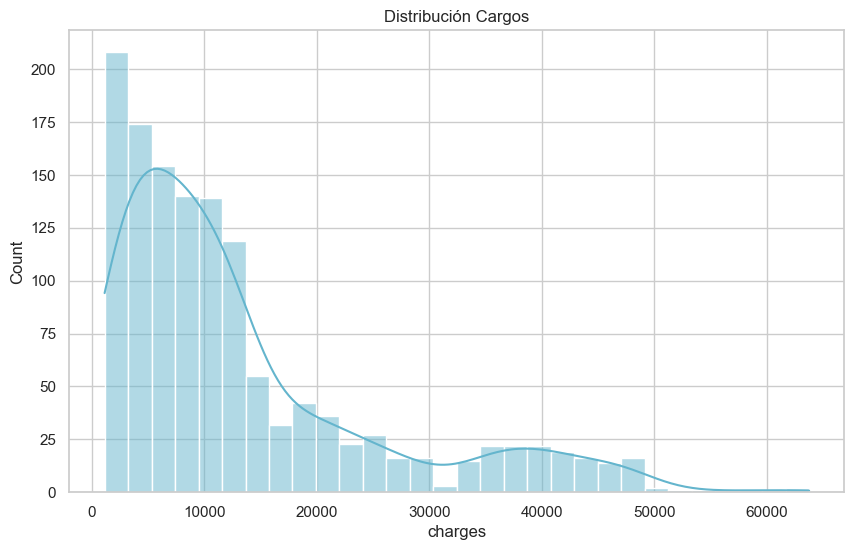

In [6]:
sns.set_theme(style='whitegrid')
f, ax = plt.subplots(1,1, figsize=(10, 6))
ax = sns.histplot(df['charges'], kde = True, color = 'c')
plt.title('Distribución Cargos')

--- 
 
Por contextos razonables, podemos estimar que personas fumadores son quienes mayor factor de riesgo poseen, por lo que presentan mayor cargo a abonar.

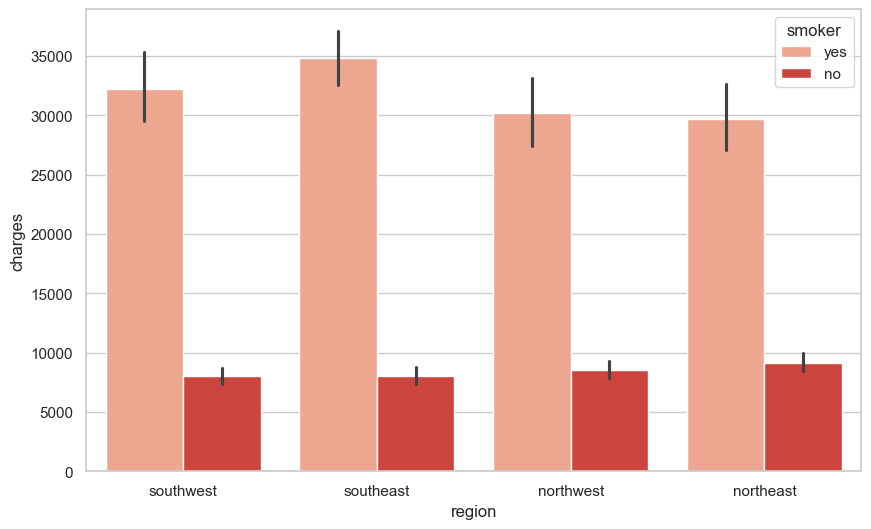

In [7]:
f, ax = plt.subplots(1,1, figsize=(10,6))
ax = sns.barplot(x = 'region', y = 'charges', hue='smoker', data=df, palette='Reds')

Aquí pueden verse los cargos para fumadores distribuídos por región.

--- 

En cuanto a la relación entre género y cobro realizado, la relación es relativamente simétrica, solo en la región sur oeste podemos notar una leve diferencia:

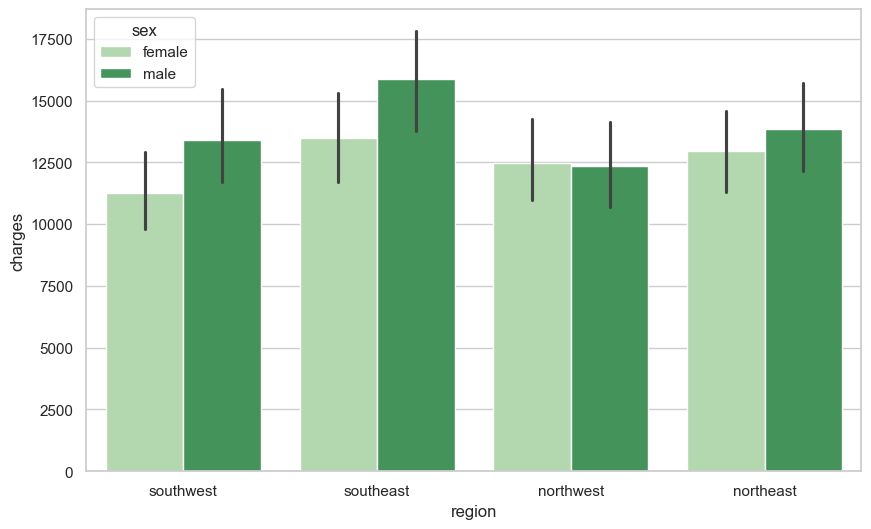

In [8]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))
ax = sns.barplot(x='region', y='charges', hue='sex', data=df, palette='Greens')

---


Veamos ahora cómo varían los gastos médicos en función de la edad, el IMC y la cantidad de hijos, considerando si las personas fuman o no.

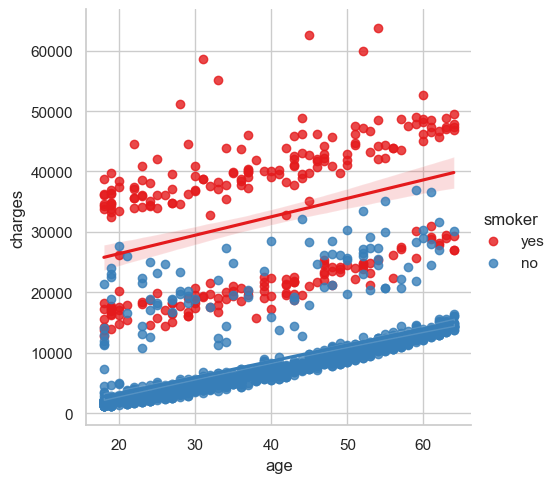

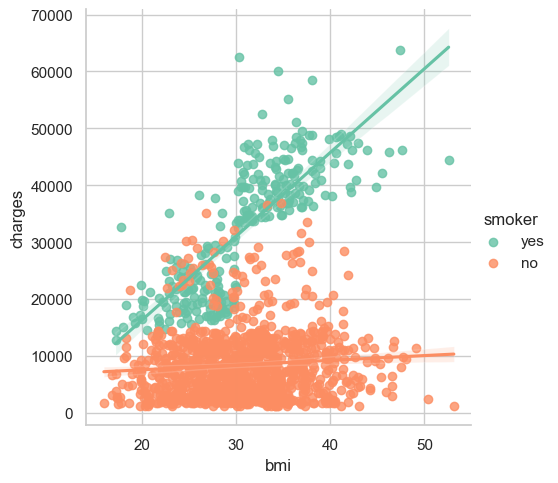

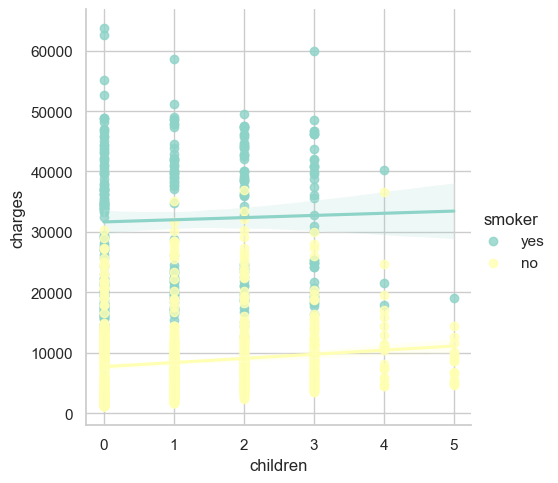

In [9]:
ax = sns.lmplot(x = 'age', y = 'charges', data=df, hue='smoker', palette='Set1')
ax = sns.lmplot(x = 'bmi', y = 'charges', data=df, hue='smoker', palette='Set2')
ax = sns.lmplot(x = 'children', y = 'charges', data=df, hue='smoker', palette='Set3')

Fumar es el factor que más influye en los costos médicos, aunque estos también aumentan con la edad, el IMC y el número de hijos. Además, las personas con hijos tienden a fumar menos, algo que también se refleja en los diagramas a continuación.

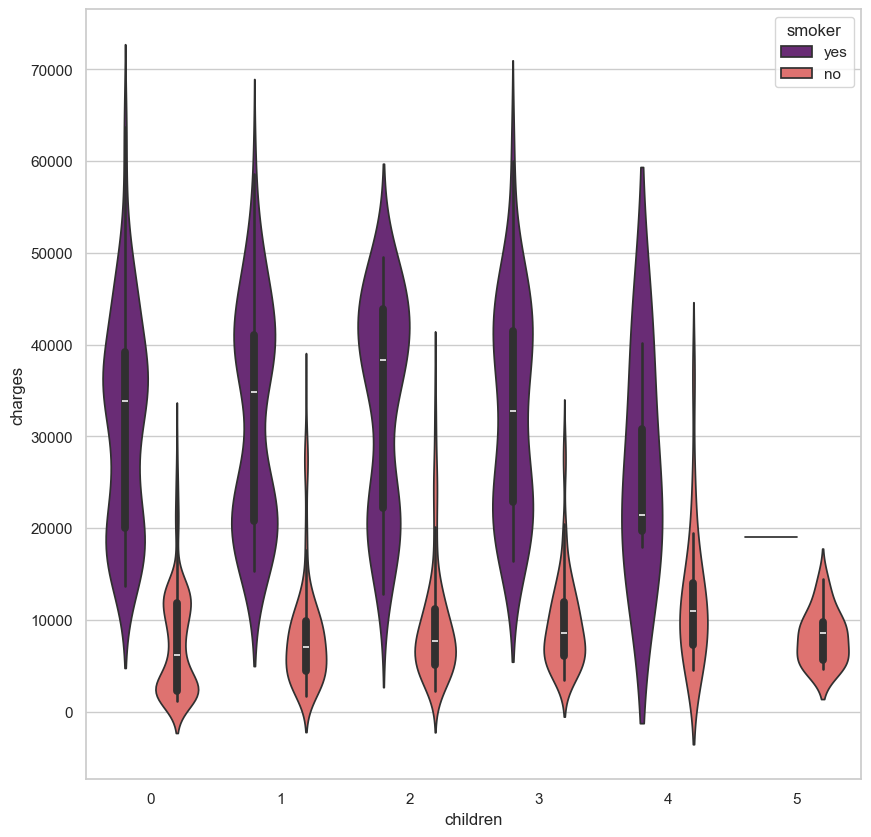

In [10]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.violinplot(x = 'children', y = 'charges', data=df, orient='v', hue='smoker', palette='magma')

## Procesamiento de datos y análisis de Algoritmos

Vamos a convertir los datos de las columnas cuyos formatos no podrían ser analizados mediante una regresión del tipo lineal, que será el primer ejemplo que utilizaremos parra la predicción:

- Dado que son pocas columnas para este dataset, no es necesario realizar un descarte de columnas, y también como vimos anteriormente no contamos con campos vacíos.
- Aplicaremos entonces un Encoder para transformar las columnas objetos en datos legibles

In [11]:
column=['sex','smoker','region']

df[column] = df[column].apply(LabelEncoder().fit_transform)

df.head

<bound method NDFrame.head of       age  sex     bmi  children  smoker  region      charges
0      19    0  27.900         0       1       3  16884.92400
1      18    1  33.770         1       0       2   1725.55230
2      28    1  33.000         3       0       2   4449.46200
3      33    1  22.705         0       0       1  21984.47061
4      32    1  28.880         0       0       1   3866.85520
...   ...  ...     ...       ...     ...     ...          ...
1333   50    1  30.970         3       0       1  10600.54830
1334   18    0  31.920         0       0       0   2205.98080
1335   18    0  36.850         0       0       2   1629.83350
1336   21    0  25.800         0       0       3   2007.94500
1337   61    0  29.070         0       1       1  29141.36030

[1338 rows x 7 columns]>

* Comenzaremos ahora con una carga y entrenamiento para una regresión lineal de la biblioteca de scikit-learn, donde solicitaremos luego que nos de información sobre los coeficientes obtenidos para validar como ha impactado.

In [12]:
x = df.drop(['charges'], axis = 1)
y = df['charges']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
Lin_reg = LinearRegression()
Lin_reg.fit(x_train, y_train)
print(Lin_reg.intercept_)
print(Lin_reg.coef_)
print(Lin_reg.score(x_test, y_test))

-11827.7331417957
[  256.5772619    -49.39232379   329.02381564   479.08499828
 23400.28378787  -276.31576201]
0.7911113876316934


* Utilizaremos ahora como herramienta una regresión Polinomial, para llegar a un valor más alto de r2 sobre la misma línea trabajada en la regresión lineal,  modelando relaciones no lineales entre las variables independientes y la variable dependiente. Emplearemos por defecto el grado 2 para enteros.

In [13]:
from sklearn.preprocessing import PolynomialFeatures
x = df.drop(['charges', 'sex', 'region'], axis = 1)
y = df.charges
pol = PolynomialFeatures (degree = 2)
x_pol = pol.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x_pol, y, test_size=0.3, random_state=0)
Pol_reg = LinearRegression()
Pol_reg.fit(x_train, y_train)
y_train_pred = Pol_reg.predict(x_train)
y_test_pred = Pol_reg.predict(x_test)
print(Pol_reg.intercept_)
print(Pol_reg.coef_)
print(Pol_reg.score(x_test, y_test))

-8062.393521836057
[ 0.00000000e+00  2.38837671e+01  6.20407258e+02  4.74983375e+02
 -9.65250235e+03  2.71964771e+00  6.23476250e-01  1.17005555e+01
  9.46075140e+00 -1.00004263e+01  4.14764376e-01  1.40301017e+03
 -7.39829496e+01 -2.81962404e+02 -9.65250235e+03]
0.8750334947519978


Podemos observar que el puntaje obtenido ha mejorado, por lo que ya podemos obtener algunas afirmaciones:

* El valor -8062.393521836057 corresponde a los cargos cuando todas las variables independientes (edad, IMC, hijos, fumador) son cero. Aunque no tiene un significado práctico directo, es una parte necesaria del modelo.
* El Coeficiente de Determinación 87.50% nos muestra la variabilidad en los cargos, que puede ser explicada por este modelo de regresión polinomial. Esto indica un ajuste muy bueno del modelo a los datos. 
* Las variables edad, el IMC, el número de hijos y si la persona es fumadora tienen un impacto significativo en los costos de seguro, mejorando el ajuste en comparación con el modelo de regresión lineal simple.

Sin embargo, tal vez consecuencia del número total de casos a analizar, si efectuamos un segundo análisis teniendo en cuenta la presencia de casos Outliners, impactará de lleno en las predicciones que podamos realizar con ambos modelos, sobre los cargos que se efectúan a los beneficiarios.

---

## Revisión mediante análisis de Outliners

Mediante este gráfico Boxplot, vemos la presencia de datos Outliners en los cargos cobrados:

<Axes: ylabel='charges'>

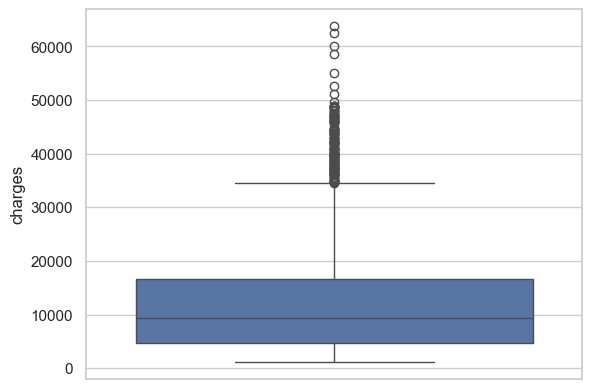

In [14]:
sns.boxplot(data=df['charges'])

Definimos en el dataset los cuantiles superior e inferior para determinar sus límites, y procedemos luego a retirarlos del análisis. 

In [15]:
def outliners(data,feature):
    
    q1 = data[feature].quantile(0.25)
    q3 = data[feature].quantile(0.75)
    iqr = q3 - q1
    lower_limit = q1 - iqr *1.5
    upper_limit = q3 + iqr *1.5

    ls = data.index[(data[feature]<lower_limit) | (data[feature]>upper_limit)]

    return ls


def remove(df,ls):

    ls = sorted(set(ls))
    df = df.drop(ls)
    return df

In [16]:
# obtención de outliers
index_list = []
index_list.extend(outliners(df,'charges'))

- Veremos una reducción en el tamaño de la muestra, no es significativa en cantidad pero si en los valores que imputaban:

In [17]:
df = remove(df,index_list)
df.shape

(1199, 7)

Esto impacta significativamente en los puntajes obtenidos para los coeficientes de determinación, tanto para el modelo lineal como para el polinomial:

In [18]:
x = df.drop(['charges'], axis = 1)
y = df['charges']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
Lin_reg = LinearRegression()
Lin_reg.fit(x_train, y_train)
print(Lin_reg.intercept_)
print(Lin_reg.coef_)
print(Lin_reg.score(x_test, y_test))

-2424.297213314054
[  240.2545712   -223.29483394    63.5520952    439.92889015
 14203.69226138  -598.83153269]
0.6262218092603857


In [19]:
from sklearn.preprocessing import PolynomialFeatures
x = df.drop(['charges', 'sex', 'region'], axis = 1)
y = df.charges
pol = PolynomialFeatures (degree = 2)
x_pol = pol.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x_pol, y, test_size=0.2, random_state=0)
Pol_reg = LinearRegression()
Pol_reg.fit(x_train, y_train)
y_train_pred = Pol_reg.predict(x_train)
y_test_pred = Pol_reg.predict(x_test)
print(Pol_reg.intercept_)
print(Pol_reg.coef_)
print(Pol_reg.score(x_test, y_test))

-217.13206432920015
[ 0.00000000e+00 -1.28593889e+02  2.58293435e+02  1.99466292e+03
 -8.52666427e+02  5.33150868e+00 -9.16594554e-01 -1.35502414e+01
 -8.85605928e+01 -3.45430483e+00 -4.68778848e+00  7.54836613e+02
 -1.67550143e+02 -3.03060979e+02 -8.52666427e+02]
0.674279851098028


Con esto podemos saber que si bien el método de regresión Polinomial sigue siendo mejor en la predicción que el método lineal, nos da un margen de mejora para el método de predicción. Con esto deberíamos analizar un aumento de la cantidad de datos a ingresar a nuestro modelo para entrenar y reducir el impacto de outliners. Otros métodos podrían aplicarse para el análisis, pero en resumen nos dieron resultados parciales similares.